Decided to use PyTorch. Keras was giving me quite a headache with it's abstractions.

In [1]:
# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

# Misc. Imports
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./lesion-csv.csv")
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# All we care about at this point is the id and class
train_df = train_df.drop(["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)
test_df = test_df.drop(["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

partition = {
    "train": train_df.imageId.values,
    "validation": test_df.imageId.values,
}

In [3]:
n = 65
print(train_df.iloc[n, 0])
print(train_df.iloc[n].imageId)

0130-1
0130-1


In [4]:
class TeethLesionDataset(Dataset):
    """Teeth Lesion dataset."""
    
    def __init__(self, train_frame, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image ids and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.lesions_train_frame = train_frame
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.lesions_train_frame)
    
    def __getitem__(self, idx):
        image_id = self.lesions_train_frame.iloc[idx].imageId
        image = cv2.imread(self.root_dir + image_id + '.jpg')
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
        label = self.lesions_train_frame.iloc[idx].lesion
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [34]:
lesion_dataset = TeethLesionDataset(train_df, './lesion_images/all_images_processed/', transforms.ToTensor())
validation_set = TeethLesionDataset(test_df, './lesion_images/all_images_processed/', transforms.ToTensor())

0 torch.Size([3, 224, 224])


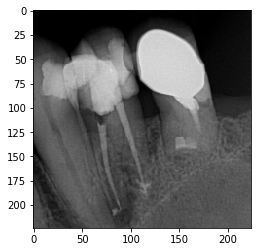

1 torch.Size([3, 224, 224])


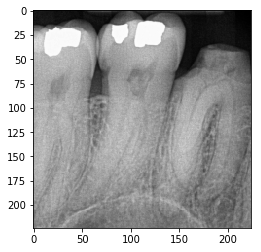

2 torch.Size([3, 224, 224])


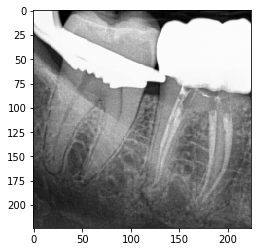

3 torch.Size([3, 224, 224])


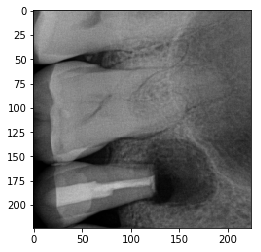

In [42]:
dataloader = DataLoader(lesion_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


for i_batch, sample_batched in enumerate(dataloader):
    images, labels = sample_batched
    print(i_batch, images[0].shape)
    tensor_image = images[0]
    plt.imshow(tensor_image.permute(1, 2, 0))
    plt.show()

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [50]:
class CNN_Model(nn.Module):
    
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        
        self.dataloader = dataloader
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.out_act = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x1 = x.view(-1, 16 * 53 * 53)
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
#         x1 = self.out_act(x1)
        
        return x1

    
class CNN:
    
    def __init__(self, dataloader, model):
        self.dataloader = dataloader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        self.model = model
        self.running_loss = 0.0
        self.num_epochs = 2
        
        self.register_hooks("conv2")
        
    def register_hooks(target_layer):

        def backward_hook(module, grad_in, grad_out):
            self._last_grad = grad_out[0]

        for layer_name, layer in self.model.named_modules():
            if layer_name == target_layer:
                layer.register_forward_hook(forward_hook)
                layer.register_backward_hook(backward_hook)
                gradient_layer_found = True
                break
    
    def train(self):
        print('Starting Training')
        for epoch in range(self.num_epochs):  # loop over the dataset multiple times
            for i, data in enumerate(self.dataloader, 0):
                # get the inputs
                inputs, labels = data

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                classification = self.model(inputs)
                
                # attention map stuff?
                # Eq 1
                classification_weights = F.avg_pool2d(
                    self._last_grad, 
                    (self._last_grad.shape[-2], self._last_grad.shape[-1]),
                    1)
                new_shape = (
                    classification_weights.shape[0] * classification_weights.shape[1], 
                    classification_weights.shape[2], classification_weights.shape[3])
                classification_weights_reshaped = classification_weights.view(new_shape).unsqueeze(0)
                
#                 out1, out2 = self.model(inputs)
                loss = self.criterion(classification, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                self.running_loss += loss.item()
                if i % 50 == 49:    # print every 20 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, self.running_loss / 2000))
                    plt.imshow(inputs[0].permute(1,2,0))
                    self.running_loss = 0.0

        print('Finished Training')
    
    def predict(self, validation_set):
        testloader = DataLoader(validation_set, batch_size=4,
                        shuffle=True, num_workers=4)

        correct1 = 0
#         correct2 = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                out1 = self.model(images)
#                 out1, out2 = net(images)
                _, predicted1 = torch.max(out1.data, 1)
#                 _, predicted2 = torch.max(out2.data, 1)
                total += labels.size(0)
                correct1 += (predicted1 == labels).sum().item()
#                 correct2 += (predicted2 == labels).sum().item()

        print('Accuracy of the network on the test images: %d %%' % (100 * correct1 / total))
#         print('Accuracy of the network on the test images: %d %%' % (100 * correct2 / total))

In [51]:
cnn_model = CNN_Model(2)
cnn = CNN(dataloader, cnn_model)

Starting Training
[1,    50] loss: 0.017
[1,   100] loss: 0.017
[1,   150] loss: 0.017
[1,   200] loss: 0.017
[1,   250] loss: 0.017
[2,    50] loss: 0.029
[2,   100] loss: 0.017
[2,   150] loss: 0.017
[2,   200] loss: 0.017
[2,   250] loss: 0.017
Finished Training


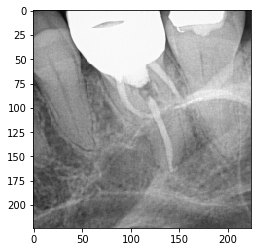

In [52]:
cnn.train()

In [53]:
cnn.predict(validation_set)

Accuracy of the network on the test images: 49 %


I think what I need to do, is to create an initial classification model to load into the Attention Map class. From there I can define a new forward pass that will use the classification output of that model.

I can also define the layer names in that model and use the register hooks function to apply a backward hook to the last conv layer

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [58]:
for idx, m in net.named_modules():
    print("index: ", idx)
    print("layer: ", m)

index:  
layer:  Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (out_act): Sigmoid()
)
index:  conv1
layer:  Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
index:  pool
layer:  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
index:  conv2
layer:  Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
index:  conv3
layer:  Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
index:  fc1
layer:  Linear(in_features=44944, out_features=120, bias=True)
index:  fc2
layer:  Linear(in_features=120, out_features=84, bias=True)
index:  fc3
layer:  Linear(in_features=84, out_f